# 第4回Pythonで実践する深層学習勉強会

<center>
浅川伸一 __asakawa@ieee.org__
</center>


# 計算グラフ Computation graph 編

[TensorFlow](https://www.tensorflow.org/) や [Theano](http://deeplearning.net/software/theano/) では ``計算グラフ`` の概念を用いている。２０１５年 Chris Olah が誤差逆伝播の演算を計算グラフを用いて説明する[ブログ](https://colah.github.io/posts/2015-08-Backprop/)を書いている。[日本語訳](http://postd.cc/2015-08-backprop/)もなされているので参照されたい。

本ページは [goo.gl/nrdsxM](goo.gl/nrdsxM)を参考にした。

---

## 計算グラフの定義

TensorFlow (以下 tf と略記)は ``計算グラフ``の考え方を理解する必要がある。具体的なプログラミングの流れとしては

1. 計算の設計図である計算グラフを定義し
2. 定義した計算の操作を実行する

となる。tf のコードを書く場合，手順 1.では定義だけで計算は実行されない。手順 2.で実際の計算が行われる(tf の場合 `Session`) 。
以下にサンプルコードを示す：

In [ ]:
import tensorflow as tf

with tf.Graph().as_default() as g:
  x = tf.Variable(1.0, name="x")
  add_op = tf.add(x, tf.constant(1.5))
  assign_op = tf.assign(x, add_op)
  init = tf.initialize_all_variables()
  with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_op)
    print(sess.run(x))

---

1行目は tf の `import` 文である。
2行目の `Graph` はデータ処理の流れとしてグラフの定義を行う。tf の計算はデータ処理フローをグラフとして定義される。
`グラフ` の要素には `演算 Operation` と `Tensor テンソル` がある。

- `演算 Operation`: 計算単位を表現するためのオブジェクト
- `テンソル Tensor`: データ処理間のデータ処理単位を表現するためのオブジェクト

デフォルトの `グラフ` を宣言することでメモリ上に登録し，`tf.get_default_graph()` を呼び出すことで演算を実行する。
デフォルトのグラフにある演算を追加するには，`演算 Operation` を呼び出せばよい。

```python
import tensorflow as tf

with tf.Graph().as_default():
```

`as_default()` 関数は後続する `変数 Variable` と `演算 Operation` を `tf.Graph()` で作成されたグラフに追加する。<br>
次の行は `定数 constant` を作成しているが `c` に代入という `演算` が **実行されるわけではない**。

```python
  c = tf.constant(1.5)
```

この行が実行されることで設計図が作成されるが `変数 c に値を代入する` という演算は行われない。

次の行では `変数 Variable` を生成している:

    x = tf.Variable(1.0, name="x")

この行を実行することでグラフに `変数 Variable` を作成することになる。

実際には上の１行で３つオブジェクトが生成される：

1. `変数` ノード
2. 定数
3. 代入という演算

<!--
When Python executes the code `x = tf.Variable(1.0, name="x")`, the `Variable`
is declared, but has not been allocated or initialized. The `Variable` is also
assigned the name we passed in. As you can see in the figure, TensorFlow takes
the name and appends ":0" to it to get "x:0" as the final Tensor's name.
-->
Python で `x = tf.Variable（1.0, name="x"）` というコードを実行すると `x` という名前を持つ変数が宣言されるが，
メモリ割り当てはなされない。初期化もされない。
<!-- 「変数」もまた
私たちが渡した名前が割り当てられています。図でわかるように、TensorFlowは
--> tf は名前に `:0` を付加して `テンソル名x:0` となる。

<!--
It can help to understand how objects are named in TensorFlow. Each operation is
given a unique name. In the case of the node for the `Variable`, we've created
an operation of type `VariableOp` that is named "x" that produces a Tensor. This
tensor is a writable reference type (`tf.float32_ref`) named "x:0".
-->

tf におけるオブジェクト命名規則に従い，各操作で生成される `Variable` ノードにおいて名前 `x` を付与する場合番号を付加して `:0` という書き込み可能な参照型 (`tf.float32_ref`) の名前 "x:0" を得る。

* `テンソル` は一連の操作によって付与される名前オブジェクトであり，連番が付加される。 `VariableOp` は常に 1 つの出力を持つのでテンソル名は "x:0" となる。`tf.split` などの演算は複数のオブジェクトを生成する。例えば `tf.split(0, 2, input, name='x'）` では 2 つの出力テンソル "x:0" と "x:1" とを生成する。

* 既に存在する名前が割り当てられている場合は tf はアンダースコアと数字を追加することで一意性を保証する。"x" という名前の 2 番目の変数を宣言すれば "x_1:0" となる

<!--
* `Tensors` are named after the operation and are sequentially numbered. A
    `VariableOp` always has one output, so the Tensor is named "x:0". Some
    operations, such as `tf.split` produce multiple outputs. For example,
    `tf.split(0, 2, input, name='x')` would produce two output Tensors named
    "x:0" and "x:1".
    
* If an operation is assigned a name that already exists in the graph, then
    TensorFlow ensures uniqueness by appending an underscore and number. For
    example, declaring a second Variable named "x" would yield a name of
    "x_1:0".
-->

** Python変数** `x` はそのノードへの参照を含むが，この時点ではインスタンス化されていないので `Variable` の値にアクセスすることはできない。定数と `assign` 演算子を加えることで変数 `Variable` を初期化することができるようになる。`assign` によって返された参照により `Variable` の値への参照が許されるようになる。返された参照は `assign` 演算を実行させるために実行されなければならない。
`tf.initialize_all_variables（）`を実行した後 `assign` 演算を行う必要がある。
冗長に見えるかもしれないが以下のコードである：

```python
    add_op = tf.add(x, c)
```

以下のコードで名前 `x` に `変数 Variable` を割り当てることができる。

```python
    assign_op = tf.assign(x, add_op)
```

数値を追加して結果を `Variable` に戻す前に `変数 ` を初期化する必要がある。
`Session.run()` を呼び出す前に，必ず `tf.initialize_all_variables()` を実行して
全変数を初期化してから `Session.run()` を実行する。

```python
    init = tf.initialize_all_variables()
```

この操作により `assign()` で，変数を割り当て，初期化される。

上記はまだ設計図を描いただけであり，計算は実行されない。
定義した計算グラフが **実行** されると，加算が実行される。計算グラフの実行は `Session` で行う。

```python
  with tf.Session() as sess:
```

![Create graph](images/graph-01-06.png)

```python
  with tf.Session() as sess:
    sess.run(init)
```

計算が実行されると下図のようになる：

![Call init](images/graph-01-07.png)

図のように `tf.initialize_all_variables` 演算子に接続された部分グラフが実行される。

一番上の `assign` を実行すれば tf は依存関係を自動的に判断して実行する。
この場合 `assign` 演算子は `add` の演算結果に依存するので最初に `add` が実行される。

```python
    sess.run(assign_op)
```

下位グラフの計算すると：

![Assign op dependencies](images/graph-01-09.png)

加算の実行：
![Add op running](images/graph-01-10.png)

---

変数に値を保存する

![Assignment op running](images/graph-01-11.png)

以上により以下の結果を得る：

```python
    print(sess.run(x))  # 2.5 と出力される
```

以下に最終的なコードを再度記す：

In [ ]:
import tensorflow as tf

with tf.Graph().as_default() as g:
  x = tf.Variable(1.0, name="x")
  add_op = tf.add(x, tf.constant(1.5))
  assign_op = tf.assign(x, add_op)
  init = tf.initialize_all_variables()
  with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_op)
    print(sess.run(x))

通常 `Graph` や `Session` を明示的に作成することを心配する必要はない。これらのオブジェクトは `tf.learn` のような高水準 API により自動的に作成される。多くの場合，ここに示した低レベルの操作を定義することについて心配する必要はない。
しかし tf で計算を定義する方法と実際に計算がどのように実行されるかについて基本的な概念をつかむことは有効である。
オリジナルの[チュートリアル](https://www.tensorflow.org/versions/r0.10/get_started/basic_usage.html)も参照のこと。

## tf の典型例

1. 計算の記述
    * 入出力，変数，操作，など。以下のブロック内に記述する

      with graph.as_default():
          ...

2. 定義した計算グラフをセッションを実行する `session.run()`　を呼び出すことで実行。以下のブロック内に記述する

      with tf.Session(graph=graph) as session:
          ...


---

以下では[https://github.com/DeepLearningDTU/02456-deep-learning/](https://github.com/DeepLearningDTU/02456-deep-learning/)を参考にした。

---

<!--lab1_FFN_tensorflow.ipynb-->
tf 専門用語：

[tf.placeholder](https://www.tensorflow.org/versions/r0.10/api_docs/python/io_ops.html#placeholder) は tf の計算グラフに入力データをセットするために用いる。テンソルの次元数と各次元のサイズを指定する。定義の際にサイズ指定に `None` を指定すると実行時にバッチサイズによって定まる。

[tf.Variable](https://www.tensorflow.org/versions/r0.10/api_docs/python/state_ops.html#Variable)はグラフのテンソルデータを保持，更新に用いられるのでニューラルネットワークの結合係数行列に用いられる。`None` を指定可能なのは上と同様。

[tf.Operation](https://www.tensorflow.org/versions/r0.10/api_docs/python/framework.html#Operation) はテンソルに対する計算の操作を定める。

## サンプルコード

<font color="blue">実習</font>: 
以下のコードをは中間層 1 層を数行の修正で 2 層にできる。

Epoch 0, Train Cost: 0.621	Val Cost: 0.608	 Val acc: 0.820
Epoch 100, Train Cost: 0.352	Val Cost: 0.371	 Val acc: 0.810
Epoch 200, Train Cost: 0.325	Val Cost: 0.346	 Val acc: 0.830
Epoch 300, Train Cost: 0.315	Val Cost: 0.338	 Val acc: 0.830
Epoch 400, Train Cost: 0.309	Val Cost: 0.334	 Val acc: 0.830
Epoch 500, Train Cost: 0.307	Val Cost: 0.333	 Val acc: 0.820
Epoch 600, Train Cost: 0.305	Val Cost: 0.332	 Val acc: 0.810
Epoch 700, Train Cost: 0.304	Val Cost: 0.332	 Val acc: 0.800
Epoch 800, Train Cost: 0.303	Val Cost: 0.332	 Val acc: 0.800
Epoch 900, Train Cost: 0.303	Val Cost: 0.332	 Val acc: 0.800

Test Cost: 0.272	Test Accuracy: 0.870


(<matplotlib.text.Text at 0x112ef8650>, <matplotlib.text.Text at 0x112fc2090>)

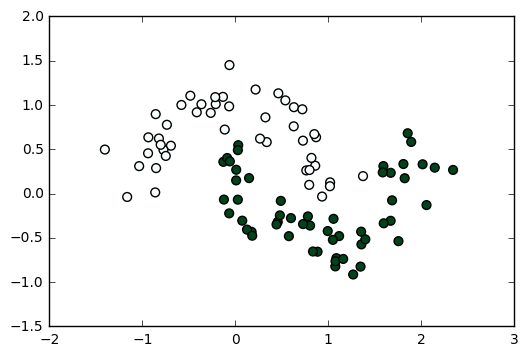

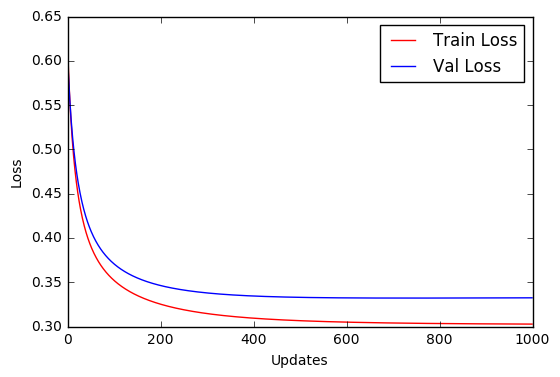

In [1]:
from __future__ import print_function
import six
import numpy as np
import sklearn.datasets
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph
import matplotlib.pyplot as plt
%matplotlib inline

# Set the seed for random number generator
np.random.seed(0)
# Set the number to be sampled
num_samples = 300

import sklearn.datasets
# set the moons dataset from scikit-learn [http://scikit-learn.org/]
X, y = sklearn.datasets.make_moons(num_samples, noise=0.20)

X_train = X[:100].astype('float32')
X_val = X[100:200].astype('float32')
X_test = X[200:].astype('float32')

y_train = y[:100].astype('int32')
y_val = y[100:200].astype('int32')
y_test = y[200:].astype('int32')

plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.BuGn)

# resets the graph, required when we will **re-initialize** weights
reset_default_graph()

# Encode one-hot manner, C. Bishop described this as 1-of-k 
def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

# Define grobal variables
num_features = X_train.shape[-1]
num_output = 2

# Setting up a placeholder
x_pl = tf.placeholder(tf.float32, [None, num_features])

#####################################################################
# Setting up variables, these variables are weights in your network
#####################################################################

# Initialize the weigths with the standard normal distribution
weight_initializer = tf.truncated_normal_initializer(stddev=0.1)
with tf.variable_scope('l_1'): 
    W_1 = tf.get_variable('W', [num_features, num_output], 
### uncomment me instead of the following
#    W_1 = tf.get_variable('W', [num_features, 100], 
                          initializer=weight_initializer)
    b_1 = tf.get_variable('b', [num_output],               
### uncomment me instead of the following
#    b_1 = tf.get_variable('b', [100], 
                          initializer=tf.constant_initializer(0.0))

# uncomment the following block for a single perceptron
#with tf. variable_scope('l_2'):
#    W_2 = tf.get_variable('W', [100, num_output],
#                          initializer=weight_initializer)
#    b_2 = tf.get_variable('b', [num_output],
#                          initializer=tf.constant_initializer(0.0))

# Define operations, these operations will set edges along with 
# the computational graph.
# The below operations will compute a logistic regression
l_1 = tf.matmul(x_pl, W_1) + b_1

# to make a hidden layer we need a nonlinearity
l_1_nonlinear = tf.nn.relu(l_1)

# the layer before the softmax should not have a nonlinearity
#l_2 = tf.matmul(l_1_nonlinear, W_2) + b_2

y = tf.nn.softmax(l_1) # for a single layer perceptron. ### uncomment me 
#y = tf.nn.softmax(l_2)

# y_ is a placeholder taking on the teacher data. 
# This notation is a traditional convention for scikit-learn
y_ = tf.placeholder(tf.float32, [None, num_output])

# computing cross entropy loss per sample
cross_entropy = -tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])

# averaging over samples
cross_entropy = tf.reduce_mean(cross_entropy)

# Defining our optimizer (try with different optimizers here!)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

# Computing our gradients
grads_and_vars = optimizer.compute_gradients(cross_entropy)

# Applying the gradients
train_op = optimizer.apply_gradients(grads_and_vars)

# making a one-hot vector
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))

# averaging the one-hot vector
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Write the graph so we can look at it in TensorBoard
# Now is a good time to try that
# https://www.tensorflow.org/versions/r0.10/how_tos/summaries_and_tensorboard/index.html
sw = tf.train.SummaryWriter('.', graph=tf.get_default_graph())
# try from command line ```tensorboard --logdir=.```

# defining a function to make predictions using our classifier
def pred(X_in, sess):
    # first we must define what data to give it
    feed_dict = {x_pl: X_in}
    # secondly our fetches
    fetches = [y]
    # utilizing the given session (ref. sess) to compute results
    res = sess.run(fetches, feed_dict)
    # res is a list with each indices representing the corresponding element in fetches
    return res[0]

# Training loop
num_epochs = 1000

train_cost, val_cost, val_acc = [],[],[]

with tf.Session() as sess:
    # initializing all variables
    init = tf.initialize_all_variables()
    sess.run(init)
    for e in range(num_epochs):
        ### TRAINING ###
        # what to feed to our train_operation
        # notice we onehot encode our predictions to change shape 
        # from (batch,) -> (batch, num_output)
        feed_dict_train = {x_pl: X_train, y_: onehot(y_train, num_output)}
        
        # deciding which parts to fetch, train_op makes the classifier "train"
        fetches_train = [train_op, cross_entropy]
        
        # running the train_op
        res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
        # storing cross entropy (second fetch argument, so index=1)
        train_cost += [res[1]]
    
        ### VALIDATING ###
        # what to feed our accuracy op
        feed_dict_valid = {x_pl: X_val, y_: onehot(y_val, num_output)}

        # deciding which parts to fetch
        fetches_valid = [cross_entropy, accuracy]

        # running the validation
        res = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
        val_cost += [res[0]]
        val_acc += [res[1]]

        if e % 100 == 0:
            print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f\t Val acc: %0.3f" 
            %(e, train_cost[-1],val_cost[-1],val_acc[-1]))

    ### TESTING ###
    # what to feed our accuracy op
    feed_dict_test = {x_pl: X_test, y_: onehot(y_test, num_output)}

    # deciding which parts to fetch
    fetches_test = [cross_entropy, accuracy]

    # running the validation
    res = sess.run(fetches=fetches_test, feed_dict=feed_dict_test)
    test_cost = res[0]
    test_acc = res[1]
    print("\nTest Cost: %0.3f\tTest Accuracy: %0.3f" %(test_cost, test_acc))
    
    # For plotting purposes
    # plot_decision_boundary(lambda x: pred(x, sess), X_te, y_te)

epoch = np.arange(len(train_cost))
plt.figure()
plt.plot(epoch,train_cost,'r',epoch,val_cost,'b')
plt.legend(['Train Loss','Val Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')